# Beautiful numbers - EDA

## Load libraries and data

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
# append the path of the parent directory
sys.path.append("..")
from lib.utils import *

In [25]:
df_raw = pd.read_csv("../data/raw/ventaNavidad.csv")

## Initial exploration

In [26]:
df_raw.info
df_raw.isna().sum()

# this is an extremely simple data frame. 
# there are no missing values and all the datatypes are int64. 
# we might want to change the data type of 'n' to 'string', as the number itself works as an id. 

year     0
n        0
sales    0
dtype: int64

### How are sales distributed per nr?  

<Axes: xlabel='n', ylabel='sales'>

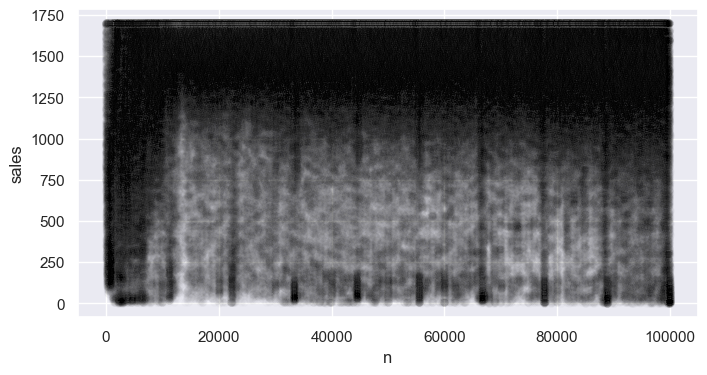

In [27]:
sns.scatterplot(data=df_raw, x='n', y='sales', color = 'black', alpha=0.02)

Some evident patterns emerge from the scatter plot.
 - on the left, the numbers starting with 0 seem to get less sales. 
 - after n = 10000, the sales seem to decrease slowly with n. 
 - there are 9 misterious columns separated with black lines... these lines might correspond to very repetitive numbers, similar to 11111, 22222 etc.

<Axes: xlabel='year', ylabel='sales'>

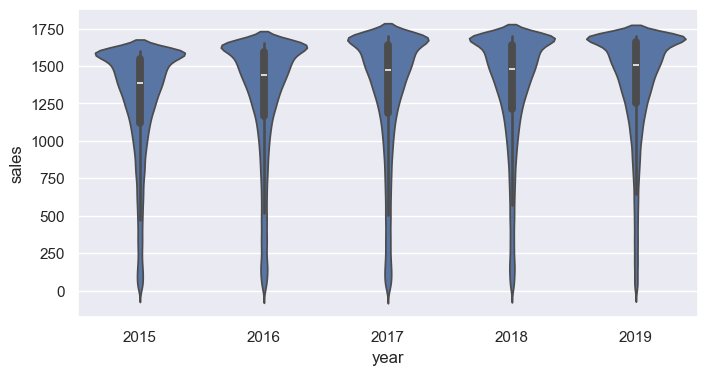

In [28]:
sns.violinplot(data=df_raw, x='year', y='sales')

The sales distribution is truncated every year by certain maximun value (the total amount of lottery tickets issued per number).
The mode coincides with this max value (i.e: most nrs sell all their "décimos"). But there's a long tail of nrs that fail to sell as much. 
The median amount of sales is lower than the mode although quite close to the higer values of each distribution. 

We could say that these distributions are quite saturated: as most nrs sell almost all their "décimos", we cannot tell if, among those, they are all equally popular. It'd be interesting to know if some of these numbers are sold out much quicklier than others, but we don't have access to that information.

In [29]:
# how many tickets sell all their nrs?

total_sales = df_raw.groupby('n').sum()
total_sales[total_sales['sales'] == total_sales['sales'].max()]

# 3202 nrs have sold all their tickets since 2015.  
# these are the beaty contest winners.

,year,sales
n,,
0,10085,8350
113,10085,8350
313,10085,8350
658,10085,8350
1013,10085,8350
...,...,...
99032,10085,8350
99113,10085,8350
99313,10085,8350


### Year by year comparison

Is the year information relevant for our analysis? Let's analyse the YoY information. 

In [30]:
df_raw[['year', 'sales']].groupby('year').describe()

sales                                                              
        count         mean         std  min     25%     50%     75%     max
year                                                                       
2015  99953.0  1256.867408  382.389965  0.0  1117.0  1385.0  1547.0  1600.0
2016  99975.0  1291.754109  410.640815  0.0  1163.0  1440.0  1595.0  1650.0
2017  99961.0  1323.101109  425.719347  0.0  1184.0  1474.0  1639.0  1700.0
2018  99855.0  1347.771459  395.401631  0.0  1213.0  1480.0  1641.0  1700.0
2019  99896.0  1380.231381  371.114193  0.0  1253.0  1506.0  1658.0  1700.0

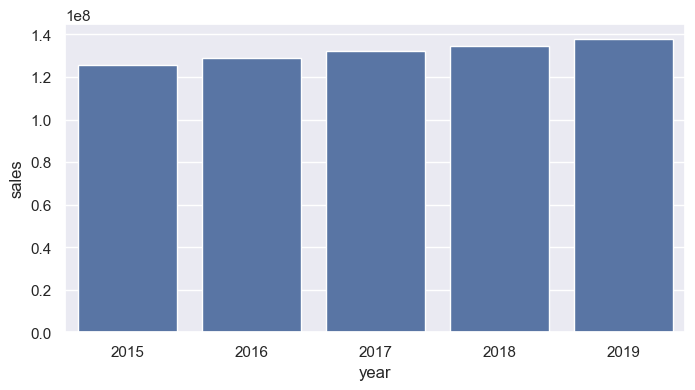

In [31]:
# we want to visualise how sales have grown by year
sns.set_theme(rc={'figure.figsize':(8,4)})

yoy_sales = df_raw[['year', 'sales']].groupby('year').sum()
ax = sns.barplot(data=yoy_sales, x='year', y='sales', estimator=sum)

Note: 
- Not all numbers come up in the dataset for every year. For instance, in 2018, only 99855 out of 100000 nrs are listed. We'll need to manage this missing values. 
- The amount of "series" issued changed between 2015 and 2017, from 160 to 170. Each "series" consists of 10000 "billetes de lotería" (one per each number), and every billete contains 10 "décimos de lotería". We'll need to normalise the sales by the total amount of "décimos" available for each nr in that year (the nr of series multiplied by 10). 
- The total amount of sales have been steadily increasing over the years. It'd be interesting to see if this was also the case in 2020 as well (more data has been requested)

### Last digit first digit exploration

In [32]:
df_digits = df_raw[['n', 'sales']].groupby('n').mean().reset_index()

# define new columns
df_digits["last"] = df_digits.index % 10
df_digits["first"] = df_digits.index // 10000
df_digits["last_2"] = df_digits.index % 100
df_digits["first_2"] = df_digits.index // 1000

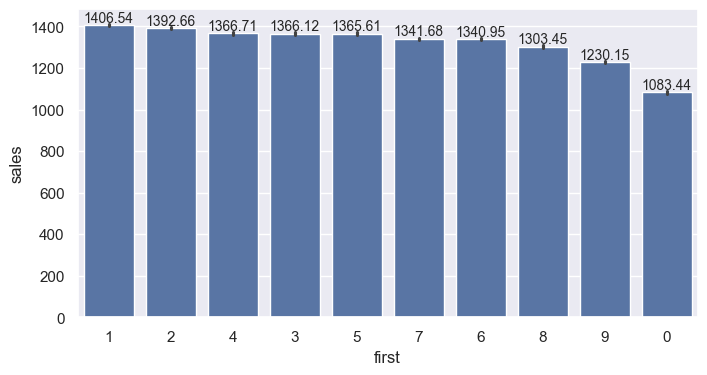

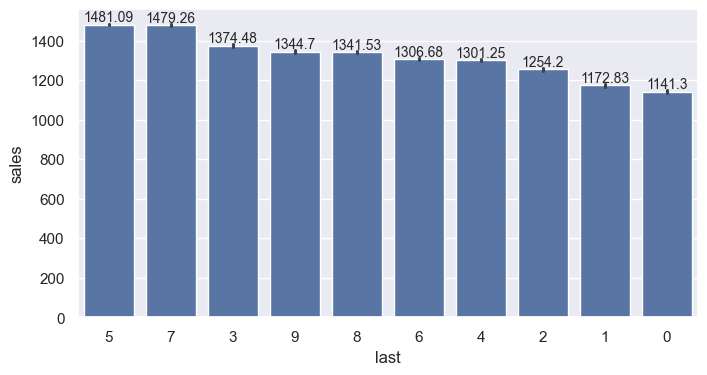

In [33]:
# plot sales distribution depending on the last or first digit
for column in ['first', 'last']:
    ax = sns.barplot(data=df_digits, x=column, y='sales', order=df_digits.groupby(column).mean().sort_values(by='sales', ascending=False).index)
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.show()

In [34]:
df_digits

,n,sales,last,first,last_2,first_2
0,0,1670.00,0,0,0,0
1,1,1667.00,1,0,1,0
2,2,1542.00,2,0,2,0
3,3,1461.00,3,0,3,0
4,4,1484.40,4,0,4,0
...,...,...,...,...,...,...
99995,99995,437.75,5,9,95,99
99996,99996,137.00,6,9,96,99
99997,99997,270.75,7,9,97,99
99998,99998,214.60,8,9,98,99


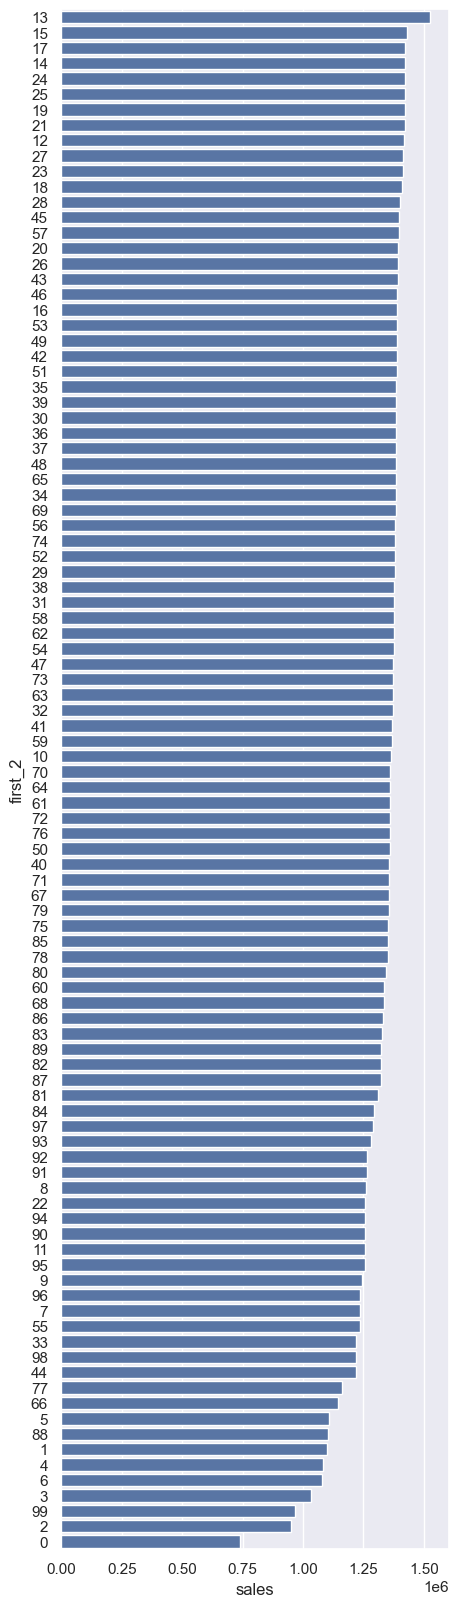

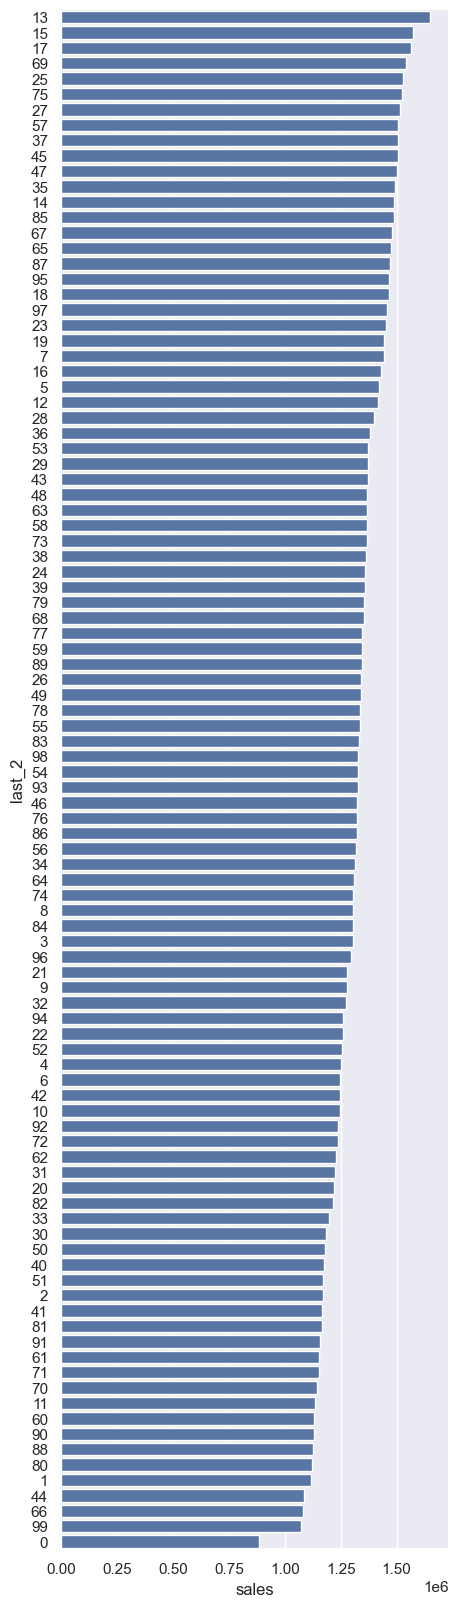

In [35]:
sns.set_theme(rc={'figure.figsize':(5,20)})
for column in ['first_2', 'last_2']:
    temp_table = df_digits.groupby(column).sum().sort_values(by='sales', ascending=False).reset_index()
    sns.barplot(temp_table, x='sales',y=column, orient = 'y', order=temp_table[column])
    plt.show()

sns.set_theme(rc={'figure.figsize':(8,4)})


## Data cleaning

### Normalise sales data: 

In [36]:
# First we'll pivot the dataframe
# We also want to normalise each year's sales so that the max value of sales = 1

df = normalise_sales(df_raw)

<Axes: xlabel='year', ylabel='sales'>

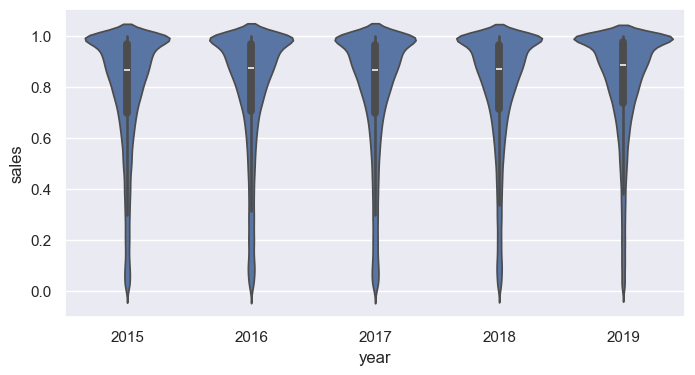

In [37]:
sns.violinplot(data=df[range(2015, 2020)].stack().reset_index().rename(columns={0:'sales'}), y='sales', x='year')


### Missing values:

There are only 347 rows with nan values, which is a low number compared to the total (less than 0.5%). 
These Nan values could point to nrs that failed to sell any "décimos", or to an error in the csv. We'll fill them in with the avg value of sales from other years for that same nr. 

In [38]:
# We want to calculate the median, mean and std of each year's sales and fill with the median value of sales for that particular number

df = get_sales_stats(df)

# save sales data
df.to_csv('../data/lottery_nr_sales.csv')

NameError: name 'get_sales_stats' is not defined

### YoY correlation: 

<Axes: xlabel='year', ylabel='year'>

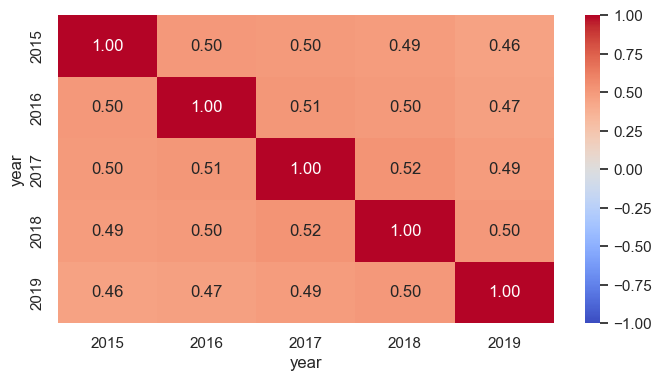

In [25]:
# let's explore the correlation matrix for the consecutive years. 
sns.heatmap(df[list(range(2015, 2020))].corr(), annot = True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')

There seems to be some amount of correlation, although this is not perfect (there are some significant changes from year to year that do not depend entirely on the nr)

<Axes: xlabel='2015', ylabel='2017'>

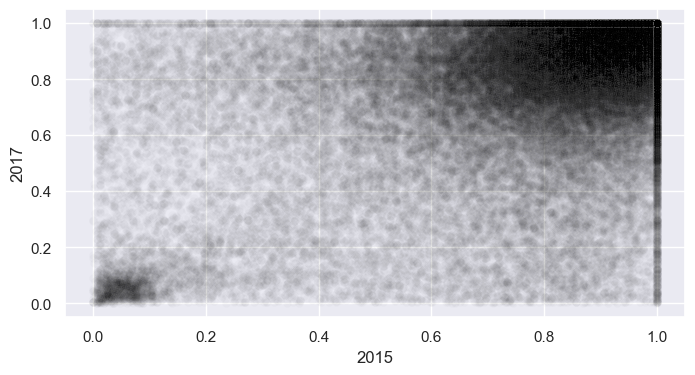

In [26]:
# Let's plot the scatter plot for a pair of years
sns.scatterplot(data=df, x=2015, y=2017, color = 'black', alpha=0.02)

It seems that some numbers (beautiful numbers) sell a lot consistently across years. 
Other numbers (ugly numbers) sell very little. 
But there's a lot of variability as well. We can use a kmeans to separate these groups. 

## Beauty metrics

Even if the results of the lottery are perfectly random, not all numbers add up the same amount of sales. We want to analyse why some numbers are perceived as more "beautiful" (or more "lucky"), and therefore are mores easily sold. 

These are some initial hypothesis: 

- Numbers that have repeated digits sell less. 
- Numbers that are part of a series (delta between 2 consecutive nrs is repeated) sell less. 
- Numbers that could be a date sell more. 
- Numbers taht start with 0 sell less. 
- Numbers that are odd sell more. 
- Numbers that end in 7 sell more. 
- Numbers that end in a prime number sell more. 
- Numbers that are perceived as more "random" (no clear pattern), sell more. 

In order to validate all these hypothesis, we will add new metrics to the df. 

In [1]:
beauty_metrics = Nr_properties()

# save beauty metrics to csv    
beauty_metrics.to_csv('../data/nr_beauty_metrics.csv', index=False)

## Variables exploration

In [22]:
features = pd.read_csv('../data/nr_beauty_metrics.csv', dtype={'str_n':str})
target = pd.read_csv('../data/lottery_nr_sales.csv')

df = features.merge(target, on='n')
df

,n,str_n,contains_13,ends_0,ends_00,ends_13,ends_15,ends_5,ends_69,ends_7,...,repeat_sum,postalcodes,2015,2016,2017,2018,2019,median,mean,std
0,0,00000,False,True,True,False,False,False,False,False,...,25,False,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,1,00001,False,False,False,False,False,False,False,False,...,17,False,0.999375,0.992727,0.998824,1.000000,1.000000,0.999375,0.998185,0.003090
2,2,00002,False,False,False,False,False,False,False,False,...,17,False,0.792500,0.991515,0.911176,0.947647,0.968235,0.947647,0.922215,0.078286
3,3,00003,False,False,False,False,False,False,False,False,...,17,False,0.816250,0.757576,0.869412,0.924118,1.000000,0.869412,0.873471,0.093938
4,4,00004,False,False,False,False,False,False,False,False,...,17,False,0.972500,0.690909,0.810000,0.970000,1.000000,0.970000,0.888682,0.133543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,99995,False,False,False,False,False,True,False,False,...,17,False,0.710000,0.292727,0.000000,0.077647,0.185187,0.185187,0.270094,0.318337
99996,99996,99996,False,False,False,False,False,False,False,False,...,17,False,0.136875,0.040606,0.027647,0.062353,0.144706,0.062353,0.082437,0.054763
99997,99997,99997,False,False,False,False,False,False,False,True,...,17,False,0.068750,0.446667,0.100846,0.132941,0.005882,0.100846,0.163560,0.195736
99998,99998,99998,False,False,False,False,False,False,False,False,...,17,False,0.104375,0.272727,0.052941,0.178824,0.036471,0.104375,0.129068,0.097587


In [39]:
df.drop('n', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   str_n                100000 non-null  object 
 1   contains_13          100000 non-null  bool   
 2   ends_0               100000 non-null  bool   
 3   ends_00              100000 non-null  bool   
 4   ends_13              100000 non-null  bool   
 5   ends_15              100000 non-null  bool   
 6   ends_5               100000 non-null  bool   
 7   ends_69              100000 non-null  bool   
 8   ends_7               100000 non-null  bool   
 9   ends_prime           100000 non-null  bool   
 10  is_odd               100000 non-null  bool   
 11  is_prime             100000 non-null  bool   
 12  odd_count            100000 non-null  int64  
 13  start_digit          100000 non-null  int64  
 14  starts_0             100000 non-null  bool   
 15  starts_00         

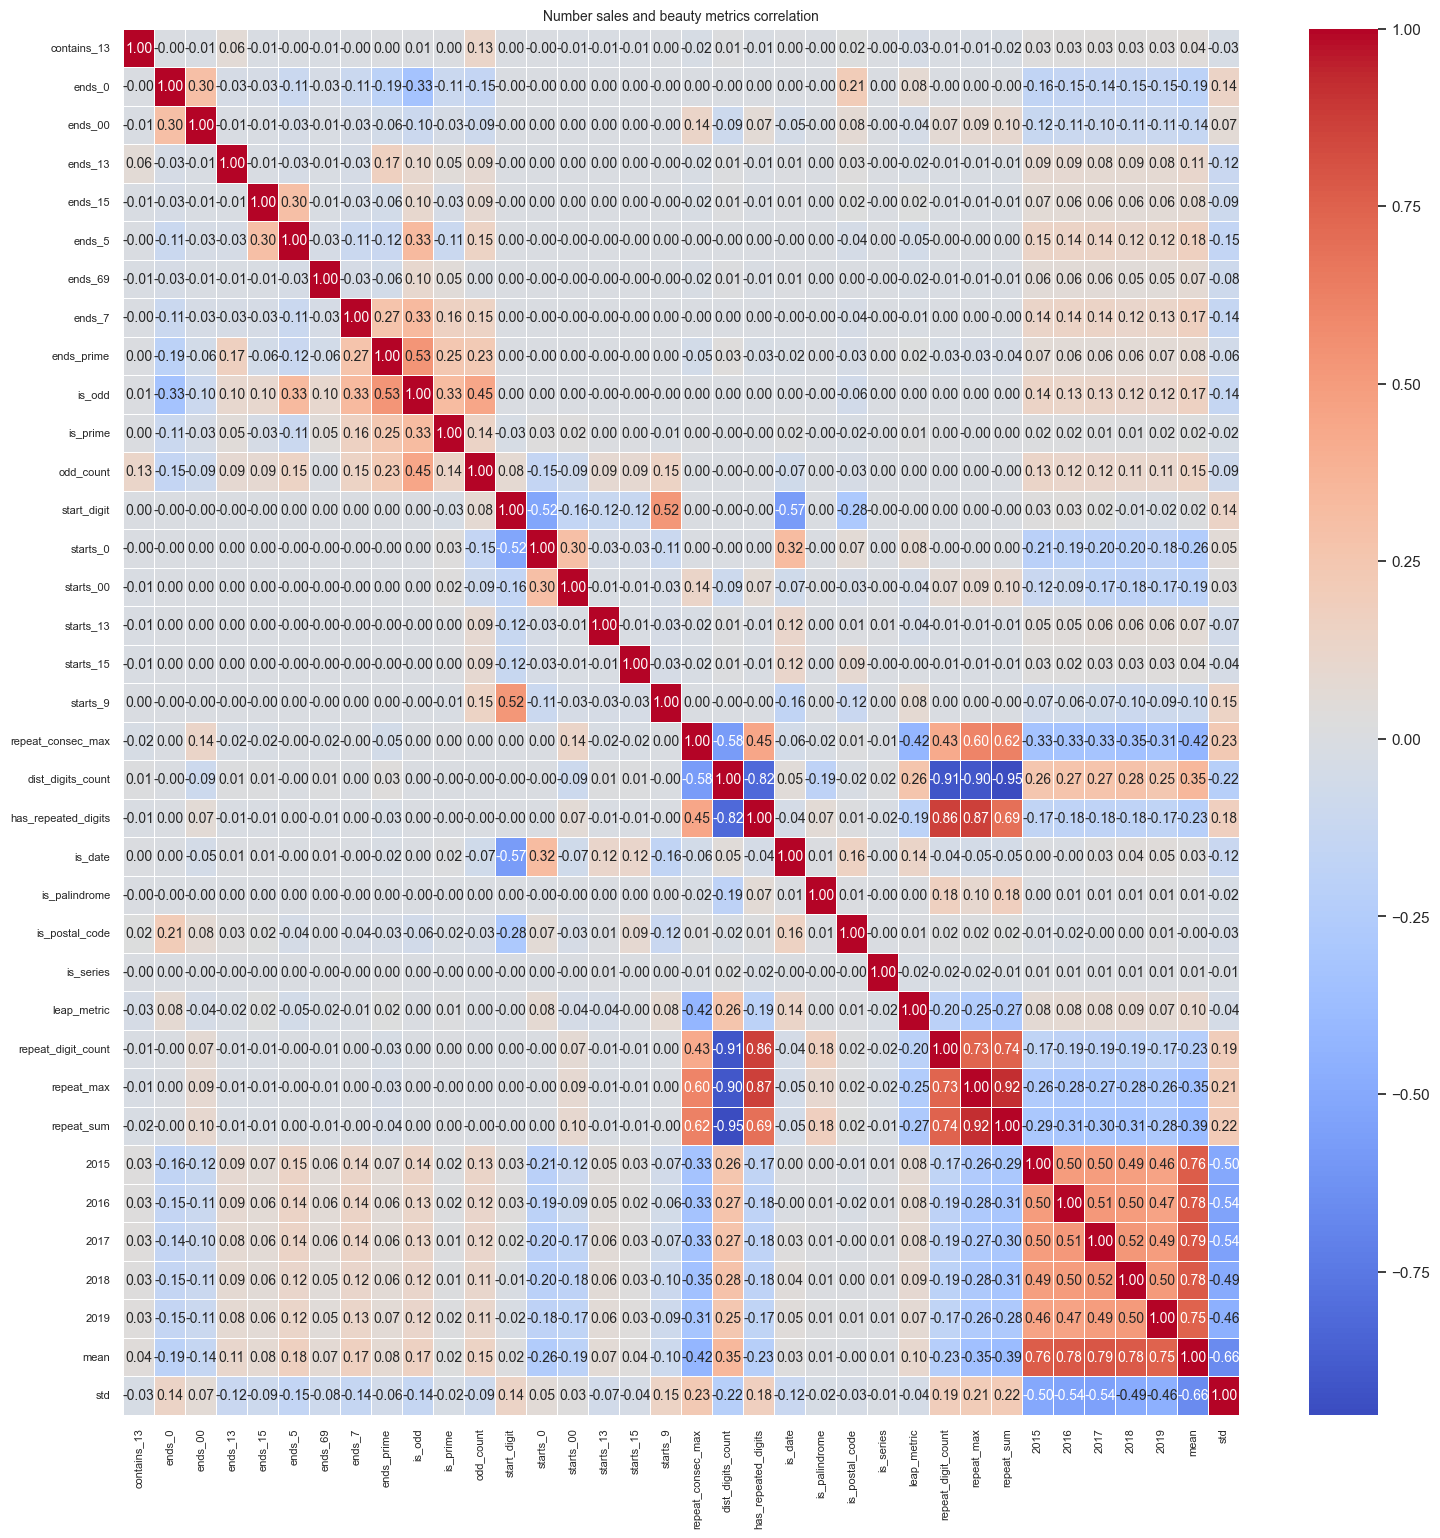

In [41]:
corr = df.drop(columns=['str_n', 'median']).corr()

# heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(corr, annot=True,fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})  # "annot_kws" controla el tamaño de las anotaciones
plt.xticks(fontsize=8)  # Cambiar el tamaño de la fuente en las etiquetas del eje X
plt.yticks(fontsize=8)  # Cambiar el tamaño de la fuente en las etiquetas del eje Y
plt.title('Number sales and beauty metrics correlation', fontsize=10)

plt.show()

In [31]:
df.columns

Index(['str_n', 'contains_13', 'ends_0', 'ends_00', 'ends_13', 'ends_15',
       'ends_5', 'ends_69', 'ends_7', 'ends_prime', 'is_odd', 'is_prime',
       'odd_count', 'start_digit', 'starts_0', 'starts_00', 'starts_13',
       'starts_15', 'starts_9', 'repeat_consec_max', 'dist_digits_count',
       'has_repeated_digits', 'is_date', 'is_palindrome', 'is_postal_code',
       'is_series', 'leap_metric', 'repeat_digit_count', 'repeat_max',
       'repeat_sum', 'mean'],
      dtype='object')

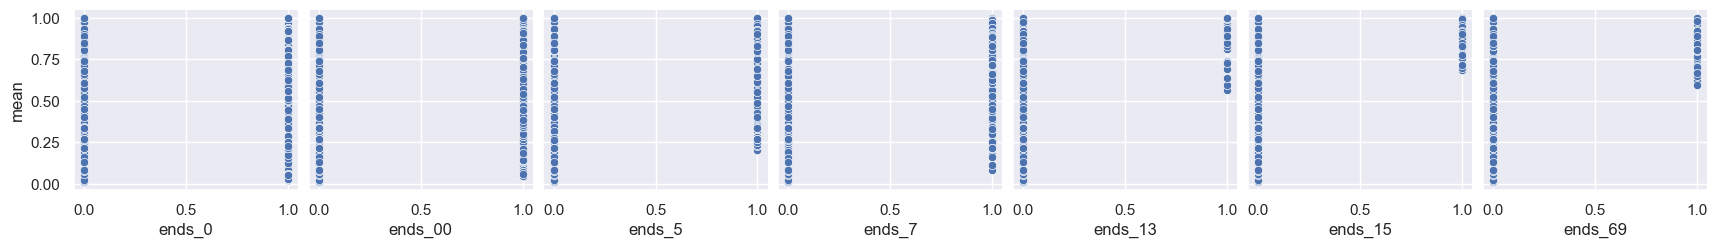

In [32]:
sns.pairplot(data=df,
            x_vars=['ends_0', 'ends_00', 'ends_5' , 'ends_7', 'ends_13', 'ends_15', 'ends_69'],
            y_vars=['mean'] 
            )

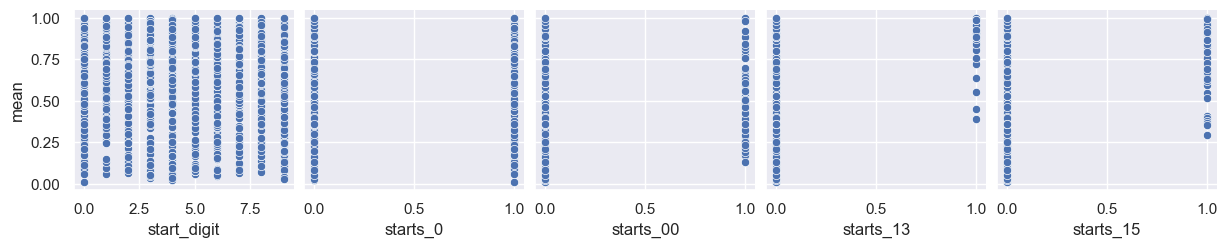

In [33]:
sns.pairplot(data=df.sample(10000),
            x_vars=['start_digit', 'starts_0', 'starts_00', 'starts_13', 'starts_15'],
            y_vars=['mean'] 
            )

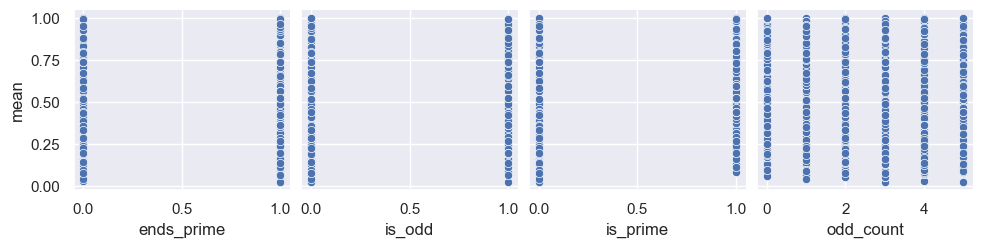

In [34]:
sns.pairplot(data=df.sample(10000),
            x_vars=['ends_prime', 'is_odd', 'is_prime', 'odd_count'],
            y_vars=['mean'] 
            )

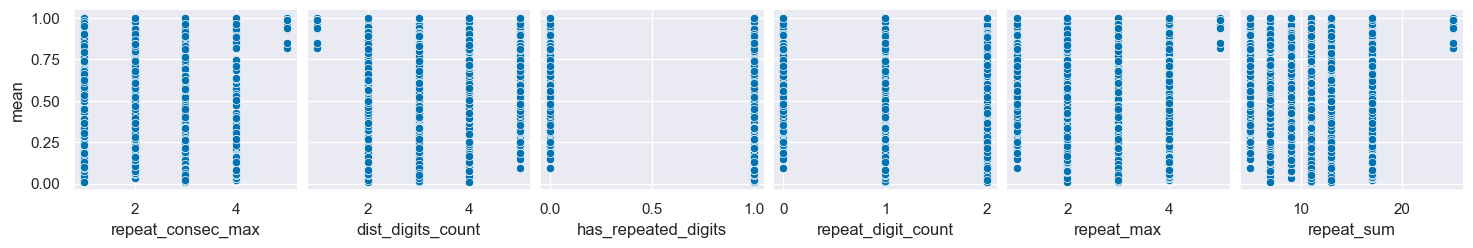

In [35]:
sns.set_theme(palette = 'colorblind')

sns.pairplot(data=df,
            x_vars=['repeat_consec_max', 'dist_digits_count', 'has_repeated_digits', 'repeat_digit_count', 'repeat_max', 'repeat_sum'],
            y_vars=['mean'] 
            )

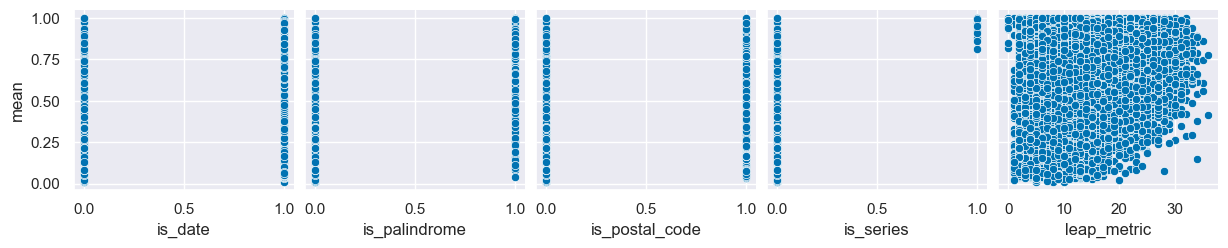

In [36]:
sns.set_theme(palette = 'colorblind')

sns.pairplot(data=df,
            x_vars=['is_date', 'is_palindrome', 'is_postal_code', 'is_series', 'leap_metric'],
            y_vars=['mean'] 
            )

<Axes: xlabel='std', ylabel='Count'>

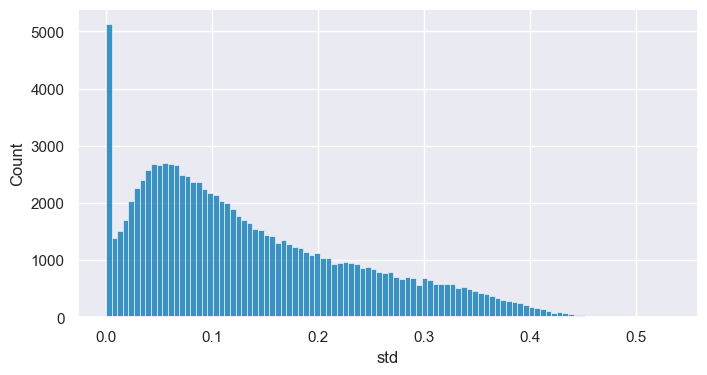

In [42]:
# How is the distribution of sales for each nr, is the std too big? 

sns.histplot(df['std'], bins=100)

# It seems that there's a bunch of numbers that always sell all the available series. These are our "beauty queens"
# The rest of the numbers have different std deviations, but the most usual value is around 0.05 -> this means, that the sales for a given number don't change a lot in different years. 
# The long tail indicates that some numbers may vary much more though, we could consider removing them from the dataset, or treat them as "noise"

In [73]:
# the numbers with high std indicate high variability: some years they get lots of sales. Other years they are not so popular. 
df[df['std'] >= 0.4]

year,2015,2016,2017,2018,2019,median,mean,std
n,,,,,,,,
1191,0.054375,0.187879,0.283529,0.982353,0.898824,0.283529,0.481392,0.428034
1484,0.155625,0.018182,0.073529,0.867647,0.783529,0.155625,0.379703,0.411040
1616,0.130000,0.941212,0.970000,0.005882,0.870588,0.870588,0.583537,0.474095
1848,0.234375,0.045455,0.620588,0.934118,0.982941,0.620588,0.563495,0.416306
2334,0.012500,0.012121,0.000000,0.932353,0.512353,0.012500,0.293865,0.418422
...,...,...,...,...,...,...,...,...
99831,0.018750,0.523030,0.979412,0.870588,0.270588,0.523030,0.532474,0.402076
99840,0.730000,0.018182,0.021176,0.943529,0.114706,0.114706,0.365519,0.438482
99842,0.074375,0.878788,0.088824,0.868824,0.794706,0.794706,0.541103,0.420755


In [81]:
# What happens when a nr wins the lottery? Do their sales chagne in some obvious way?
df[df.index.isin([3347, 71198, 66513, 79140, 13437])]

# if there are any changes these are not obvious... and these are only 5 numbers. We won't use this information for now. 

year,2015,2016,2017,2018,2019,median,mean,std
n,,,,,,,,
3347,0.811250,0.635152,0.573529,0.586471,0.996471,0.635152,0.720574,0.181138
13437,1.000000,1.000000,1.000000,0.928824,1.000000,1.000000,0.985765,0.031831
66513,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
71198,0.889375,0.817576,0.873529,1.000000,1.000000,0.889375,0.916096,0.081105
79140,0.706250,0.793333,0.837059,0.947647,0.588824,0.793333,0.774623,0.135446


<Axes: xlabel='mean', ylabel='Count'>

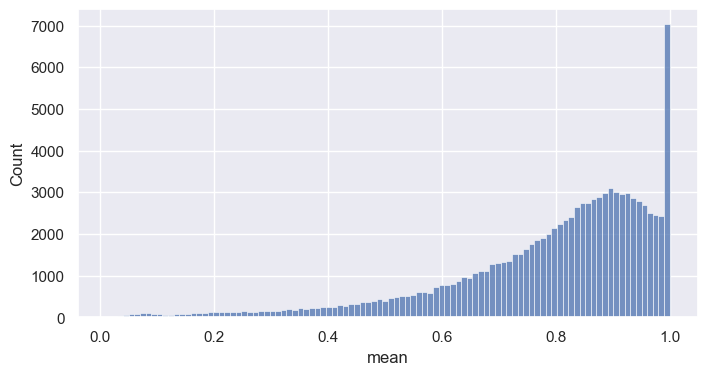

In [23]:
sns.histplot(df['mean'], bins=100)


In [1]:
a = 'ehllo'

In [2]:
a += 'world'
a

'ehlloworld'